# 2-step transpilation

Qiskit Terra [#7217](https://github.com/Qiskit/qiskit-terra/pull/7217)

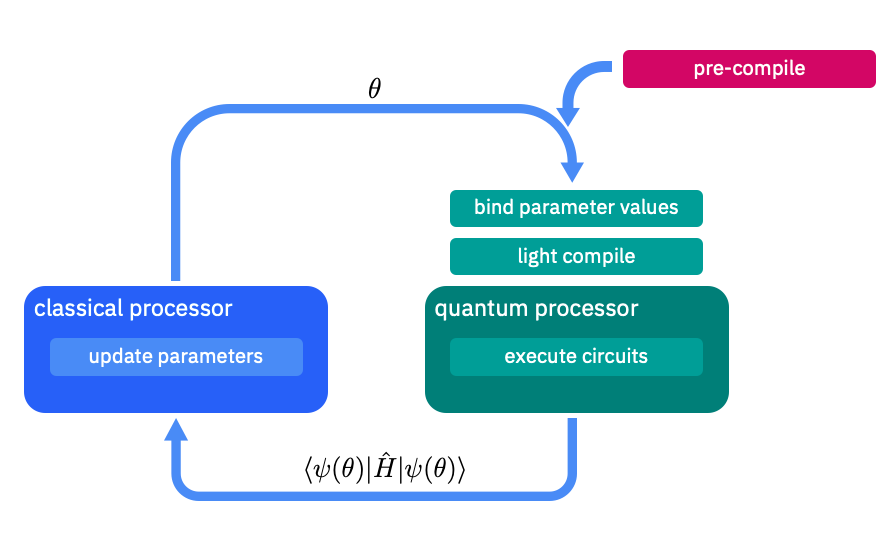

```python
from qiskit.utils import QuantumInstance

unbound_pass_manager = # some general optimizations: gate commutativites, reduce 1q gates, ...
bound_pass_manager = # parameter-specific optimization: efficient pulse decompositions

quantum_instance = QuantumInstance(
    pass_manager=unbound_pass_manager,  # "pre-compile" in the diagram
    bound_pass_manager=bound_pass_manager,  # "light compile" in the diagram
    ...
)   
```

## Toy example

In [90]:
from qiskit.transpiler import AnalysisPass

class IJustShout(AnalysisPass):
    """Pass that just prints a message."""
    
    def __init__(self, important_message):
        super().__init__()
        self.important_message = important_message
        
    def run(self, dag):
        print(self.important_message)
        return dag

In [91]:
from qiskit.transpiler import PassManager


step1_pm = PassManager(IJustShout("Calling step 1!"))
step2_pm = PassManager(IJustShout("Calling step 2!"))

In [92]:
from qiskit.providers.aer import AerSimulator
from qiskit.utils import QuantumInstance

sim = AerSimulator()

quantum_instance = QuantumInstance(sim, pass_manager=step1_pm, bound_pass_manager=step2_pm)

Let's compute the expected value of 

$$
    \langle\psi(\theta)| H \otimes H |\psi(\theta)\rangle
$$

where $|\psi(\theta)\rangle$ is prepared by the following circuit

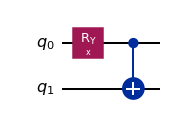

In [93]:
from qiskit.circuit import QuantumCircuit, Parameter

x = Parameter("x")

circuit = QuantumCircuit(2)
circuit.ry(x, 0)
circuit.cx(0, 1)

circuit.draw("mpl", style="iqx")

In [94]:
from qiskit.opflow import CircuitSampler, AerPauliExpectation, StateFn, H

expectation = StateFn(H ^ H, is_measurement=True) @ StateFn(circuit)
expectation = AerPauliExpectation().convert(expectation)

sampler = CircuitSampler(quantum_instance)

Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.


In [95]:
sampler.convert(expectation, {x: 1}).eval()

Calling step 1!
Calling step 2!


0.920735492403948

In [96]:
sampler.convert(expectation, {x: 0.6}).eval()

Calling step 2!


0.7823212366975174

In [97]:
sampler.convert(expectation, {x: 0.2}).eval()

Calling step 2!


0.5993346653975304

## Practical example

Set the unbound pass manager to the default Qiskit transpilation:

In [83]:
from qiskit.test.mock import FakeBelem
from qiskit.transpiler import PassManagerConfig
from qiskit.transpiler.preset_passmanagers import level_1_pass_manager

backend = FakeBelem()

unbound_pm = level_1_pass_manager(PassManagerConfig.from_backend(FakeBelem()))
unbound_pm += PassManager(IJustShout("Level 1 pass manager"))

And use pulse-efficient decomposition of two-qubit gates for the bound pass manager:

In [86]:
from qiskit.circuit.library.standard_gates.equivalence_library import StandardEquivalenceLibrary as std_eqlib
from qiskit.transpiler.passes import (
  Collect2qBlocks, ConsolidateBlocks, Optimize1qGatesDecomposition,
  RZXCalibrationBuilderNoEcho, UnrollCustomDefinitions, BasisTranslator
)
from qiskit.transpiler.passes.optimization.echo_rzx_weyl_decomposition import EchoRZXWeylDecomposition

# Build the pass manager for the parameterized circuit
rzx_basis = ['rzx', 'rz', 'x', 'sx']

# Build a pass manager for the CX decomposition (works only on bound circuits)
bound_pm = PassManager([
  IJustShout("Pulse-efficient pass manager"),
  
  # Consolidate consecutive two-qubit operations.
  Collect2qBlocks(),
  ConsolidateBlocks(basis_gates=['rz', 'sx', 'x', 'rxx']),

  # Rewrite circuit in terms of Weyl-decomposed echoed RZX gates.
  EchoRZXWeylDecomposition(backend.defaults().instruction_schedule_map),

  # Attach scaled CR pulse schedules to the RZX gates.
  RZXCalibrationBuilderNoEcho(backend),

  # Simplify single-qubit gates.
  UnrollCustomDefinitions(std_eqlib, rzx_basis),
  BasisTranslator(std_eqlib, rzx_basis),
  Optimize1qGatesDecomposition(rzx_basis),
])

Now just plug it in the VQE:

In [89]:
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import L_BFGS_B
from qiskit.opflow import Z

quantum_instance = QuantumInstance(
    backend, pass_manager=unbound_pm, bound_pass_manager=bound_pm
)

vqe = VQE(optimizer=L_BFGS_B(), quantum_instance=quantum_instance)
result = vqe.compute_minimum_eigenvalue(Z ^ Z)

Level 1 pass manager
Pulse-efficient pass manager
Pulse-efficient pass manager
Pulse-efficient pass manager
Pulse-efficient pass manager
Pulse-efficient pass manager
Pulse-efficient pass manager
Pulse-efficient pass manager
Pulse-efficient pass manager
Pulse-efficient pass manager
Pulse-efficient pass manager
Pulse-efficient pass manager
Pulse-efficient pass manager
Pulse-efficient pass manager
Pulse-efficient pass manager
Pulse-efficient pass manager
Pulse-efficient pass manager
Pulse-efficient pass manager
Pulse-efficient pass manager
Pulse-efficient pass manager
Pulse-efficient pass manager
Pulse-efficient pass manager
Pulse-efficient pass manager
Pulse-efficient pass manager
Pulse-efficient pass manager
Pulse-efficient pass manager
Pulse-efficient pass manager
Pulse-efficient pass manager
Pulse-efficient pass manager
Pulse-efficient pass manager
Pulse-efficient pass manager
Pulse-efficient pass manager
Pulse-efficient pass manager
Pulse-efficient pass manager
Pulse-efficient pass m

In [98]:
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 252,
    'eigenstate': {   '00': 0.4550068680800324,
                      '01': 0.6716932893813962,
                      '10': 0.4318835925339142,
                      '11': 0.39404750665370286},
    'eigenvalue': (-0.296875+0j),
    'optimal_parameters': {   ParameterVectorElement(θ[0]): 1.4956638078208426,
                              ParameterVectorElement(θ[1]): 1.7325015898683758,
                              ParameterVectorElement(θ[3]): -2.6155827777866407,
                              ParameterVectorElement(θ[2]): -1.854445168469083,
                              ParameterVectorElement(θ[6]): 1.245738882921631,
                              ParameterVectorElement(θ[4]): 0.35123139821310917,
                              ParameterVectorElement(θ[7]): -2.975407442468011,
                              ParameterVectorElement(θ[5]): 2.6394297992844167},
    'optimal_point': array([ 1.49566381,  1.73250159, -1.854